# Text generation with LSTM

This notebook is based on the code samples found in Chapter 8, Section 1 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff) and hosted on https://github.com/fchollet/deep-learning-with-python-notebooks. Note that the original text features far more content, in particular further explanations and figures.


In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

## Implementing character-level LSTM text generation


Let's use Keras to generate text. The first thing we need is a lot of text data that we can use to learn a 
language model. You could use any sufficiently large text file or set of text files -- Wikipedia, the Lord of the Rings, etc. In this 
example we will use some of the writings of Nietzsche, the late-19th century German philosopher (translated to English). The language model 
we will learn will thus be specifically a model of Nietzsche's writing style and topics of choice, rather than a more generic model of the 
English language.

## Preparing the data

Let's start by downloading the corpus and converting it to lowercase:

In [2]:
import keras
import numpy as np

path = keras.utils.get_file(
    'nietzsche.txt',
    origin='https://s3.amazonaws.com/text-datasets/nietzsche.txt')
text = open(path).read().lower()
print('Corpus length:', len(text))

Corpus length: 600893



Next, we will extract partially-overlapping sequences of length `maxlen`, one-hot encode them and pack them in a 3D Numpy array `x` of 
shape `(sequences, maxlen, unique_characters)`. Simultaneously, we prepare a array `y` containing the corresponding targets: the one-hot 
encoded characters that come right after each extracted sequence.

In [3]:
# Length of extracted character sequences
maxlen = 60

# We sample a new sequence every `step` characters
step = 3

# This holds our extracted sequences
sentences = []

# This holds the targets (the follow-up characters)
next_chars = []

for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('Number of sequences:', len(sentences))

# List of unique characters in the corpus
chars = sorted(list(set(text)))
print('Unique characters:', len(chars))
# Dictionary mapping unique characters to their index in `chars`
char_indices = dict((char, chars.index(char)) for char in chars)

# Next, one-hot encode the characters into binary arrays.
print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Number of sequences: 200278
Unique characters: 57
Vectorization...


In [4]:
sentences[:5]

['preface\n\n\nsupposing that truth is a woman--what then? is the',
 'face\n\n\nsupposing that truth is a woman--what then? is there ',
 'e\n\n\nsupposing that truth is a woman--what then? is there not',
 '\nsupposing that truth is a woman--what then? is there not gr',
 'pposing that truth is a woman--what then? is there not groun']

In [5]:
next_chars[:5]

['r', 'n', ' ', 'o', 'd']

## Building the network

Our network is a single `LSTM` layer followed by a `Dense` classifier and softmax over all possible characters. But let us note that 
recurrent neural networks are not the only way to do sequence data generation; 1D convnets also have proven extremely successful at it in 
recent times.

In [6]:
from keras import layers

model = keras.models.Sequential()
model.add(layers.LSTM(128, input_shape=(maxlen, len(chars))))
model.add(layers.Dense(len(chars), activation='softmax'))

Since our targets are one-hot encoded, we will use `categorical_crossentropy` as the loss to train the model:

In [7]:
optimizer = keras.optimizers.RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

## Training the language model and sampling from it


Given a trained model and a seed text snippet, we generate new text by repeatedly:

* 1) Drawing from the model a probability distribution over the next character given the text available so far
* 2) Reweighting the distribution to a certain "temperature"
* 3) Sampling the next character at random according to the reweighted distribution
* 4) Adding the new character at the end of the available text


The following code shows how we can re-adjust a probability distribution by applying different temperatures. 
* The higher the temperature, the more random the probability distribution.
* The lower the temperature, the more deterministic the probability distribution (closer to a one-hot vector).

In [8]:
probs = np.array([0.1,0.2,0.4,0.3])
probs_1 = np.exp(np.log(probs)/0.1)
probs_1 = probs_1/np.sum(probs_1)
probs_1

array([9.01997925e-07, 9.23645876e-04, 9.45813377e-01, 5.32620755e-02])

In [9]:
probs_2 = np.exp(np.log(probs)/0.01)
probs_2 = probs_2/np.sum(probs_2)
probs_2

array([6.22301528e-61, 7.88860905e-31, 1.00000000e+00, 3.20720219e-13])

In [10]:
probs_3 = np.exp(np.log(probs)/2)
probs_3 = probs_3/np.sum(probs_3)
probs_3

array([0.16270045, 0.23009319, 0.32540091, 0.28180545])

In [11]:
probs_4 = np.exp(np.log(probs)/100)
probs_4 = probs_4/np.sum(probs_4)
probs_4

array([0.24801823, 0.24974333, 0.25148043, 0.25075801])

Below is the sampling function that samples an item from a probability distribution with a temperature:

In [12]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


Finally, this is the loop where we repeatedly train and generate text. We start generating text using a range of different temperatures 
after every epoch. This allows us to see how the generated text evolves as the model starts converging, as well as the impact of 
temperature in the sampling strategy.

In [13]:
def generate_text(model, text_seed):
    "Generate text given a text seed"
    for temperature in [0.2, 0.5, 1.0, 1.2]:
        generated_text = text_seed
        print('------ temperature:', temperature)
        sys.stdout.write(generated_text)

        # We generate 400 characters
        for i in range(400):
            sampled = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(generated_text):
                sampled[0, t, char_indices[char]] = 1.

            preds = model.predict(sampled, verbose=0)[0]
            next_index = sample(preds, temperature)
            next_char = chars[next_index]

            generated_text += next_char
            generated_text = generated_text[1:]

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()    

In [14]:
import random
import sys

loss = []
for epoch in range(1, 60):
    print('epoch', epoch)
    # Fit the model for 1 epoch on the available training data
    history = model.fit(x, y,
                  batch_size=128,
                  epochs=1)
    loss.append(history.history['loss'])
    
    filename = 'generation_model_epoch%i.h5' % epoch
    model.save_weights(filename)
    print("Model saved in file", filename)

    # Select a text seed at random
    start_index = random.randint(0, len(text) - maxlen - 1)
    text_seed = text[start_index: start_index + maxlen]
    print('--- Generating with seed: "' + text_seed + '"')
    generate_text(model, text_seed)


epoch 1
Epoch 1/1
200278/200278 [==============================] - 104s 519us/step - loss: 1.9712
Model saved in file generation_model_epoch1.h5
--- Generating with seed: "ch the feeding of the family and the master of
the house is "
------ temperature: 0.2
ch the feeding of the family and the master of
the house is a man and the reason of the conscience of the great are the reast and the preary of the many and the man the from the here its as the such a man the reasure of the serrity of the whole say the man are to the conscience of the prearing and the reason of the man and the such a man as a personal and the word and the state are such the here in the constinction of the from the here in the great and the
------ temperature: 0.5
ch the feeding of the family and the master of
the house is the man and imperraps of the wordion after its the sensed world intersond a prearises that is it is a means for the end the here such how very into the flot has a man of the more soire which we cou

1uin the immen, fee xist
------ temperature: 1.2
ivers; they say: "thus shall it be!"
they determine first the childpriased inexyly have
yor, the
no gord, a wirr exusult, arty; who the neest signiuncy, herdering that of-cricual himself, what we stition--nompoles reakal
asconamisty.a uncivility of
disfined, these"sfect,
and
one hawr hink theopon, if present philosopheran stitutial hesthin aupultary,tments when a threaty in  ) sove rablitiesver punity injur. thind outinatergrning imony,--arr-insoling overs
epoch 5
Epoch 1/1
200278/200278 [==============================] - 103s 515us/step - loss: 1.4625
Model saved in file generation_model_epoch5.h5
--- Generating with seed: "n standing, and must remain
standing he himself must perhaps"
------ temperature: 0.2
n standing, and must remain
standing he himself must perhaps more than the spiritual to the sensition of the sensition of the sense of the dece is the fact of the world that the spiritual to the sense of the strength that the condit

has fallen, that all dogma lies on the ground--nature of the most part of the instance of the deep thehe is all this be instinct be pressions in the subject of a reason of the world general more are to deing consciously we have domain that he must not the should be every our worth, the fact of the cause of the disclast and prespined and allow as if i from the most spirit and more the desire to dependence and beut the warth and proper disclose be
------ temperature: 1.0
in that it
has fallen, that all dogma lies on the ground--naces are be different very greated sun echabe not respect meass courn
when without most morality of his enfneded flor my piouses was not indifferatere"; nebes"--we soceak of any something in the passions for the most
blow is way from mea hund as the being conacla--of the unimpossions of lover remarden,
souch that is, and frmat
dund, whoelt another not-mind as the revengeidable objectionable of.?

1
------ temperature: 1.2
in that it
has fallen, that all dogma lie

including the same the same to the possible of the same the same the same to the same and the primordies of interpretation of the community of the same and the same and the world be as a spirit of the most the sign of the profound to the same to the same to the profound to the problem to the same will to look of the same to the same and says to the same to the present secard to the germans as a conscious to the
------ temperature: 0.5
titude finally became opposed to their taste,
including the commander, to be literaterefjuction of the less of the prication of good to the character--the herity so the primord to the same the artist of the most consequently can decess of the species of such a the same to his power and the subligations of the same as the relation of the person of the need in the contrary to be at the distinations and says of the come and in the same as the power within to 
------ temperature: 1.0
titude finally became opposed to their taste,
including the an axplist radic

/home/diego/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


ness, in the people is and coaning i ap
meams or notesel with censuod and conduct and "ofme's
againters come us, as
the person of which the art of
consequently
evils in anything of readiness of things, and the suppose the secretive faith itself toward time
i onlighter, that eainiling i minds or mother and centu
------ temperature: 1.2
titude finally became opposed to their taste,
including the beast our bur probality of maimed: but of complocent, by their spirit,", ara with
emplobosary oppressom, premion, any love use, to have
good
man compator by
great, too 
accompined their ceaedt" shall bed b: how hobling about you ricy seem in which is certaintfathmatible with increanigation of yet, has a
reaided
phy one shepiritself
in superitisty long
upon , yagley, as through harisly species with
epoch 13
Epoch 1/1
200278/200278 [==============================] - 103s 515us/step - loss: 1.3737
Model saved in file generation_model_epoch13.h5
--- Generating with seed: "s most typical, that timidit

the exceptional man, and endeavousial from the masters of the sense to this consequence of the science, this are in his false be consider and properity, the liventing and sense of living that
this belief that has the been it is the really or as ill has from being and greatest in the very continuality and combiles a part of this deluconoming in the heart of his fact that his spirit which is not that the fact that is a be surfered
------ temperature: 1.0
vely for the destruction of
the exceptional man, and endeavous ratiching amage in things socioun) through pleaniling, as as the
valuent and egoism simply
he
ond and
things and knowledgeed to ask the own someore decivement should extradivated laws but than the self personugh, and has a man even it was
tighten bestemently in some high
expected, thinks their absolus of "costumienly be inyes good sight to ommends of trweftier. new quands might end object eart 
------ temperature: 1.2
vely for the destruction of
the exceptional man, and endea

develop out of its antithesis? for example, the reason of the same the stands which he will all the same some constand the same the man is and there is also the present the contradiction of the same the contradiction of the same still all the same all the spirit of the case of the contradiction of the standard of the contrary and not be strong that the most precisely the contradiction of the same the spirit and the words of the power in the same sen
------ temperature: 0.5
 thing
develop out of its antithesis? for example, the reason of the higher and begins of the contrary as their sense--they in the general even to the present, and than the soul-has in the same in the mask, and dereptes of the most the fundamental extent the simpless than the active the fine the man to can new the same desire the good of the contradict that he lack of believe it were the desire in man of the masters of the man is a desire of its spirit and
------ temperature: 1.0
 thing
develop out of its antithesis?

have hor europe the fact them), amidaining fellow, torm existentless becomes e curturvise, et in ordinaliss, regardation. not-could could occurred
salt is cavaltive betten heel
understood has, time undirecoring fremsal, sircore, are
beemaf,
to hamfty of
them: le thlow very selogome, the patencanation, undifferent
disma--to epje
epoch 24
Epoch 1/1
200278/200278 [==============================] - 103s 515us/step - loss: 1.3338
Model saved in file generation_model_epoch24.h5
--- Generating with seed: " and with freedom of the will, it should be
designated as th"
------ temperature: 0.2
 and with freedom of the will, it should be
designated as the same the present and the same and the the science of the sense of the same the conscious and the moral the desire the same the condition of the sense of the present and the same the present disposition and the world in the present conscious and the same the subtlest and the superiority and also and the states of the same and refined by the same a

for homeric laughter: that it seemed so much, everything except open-lating leparness reality does should personal existence.

e1e ititure-seet, has a luth an
formuline,
prodigred such a shours other-great becean of the worlds, prioration with a independence.--suspects, it is closiness for saday to itialuce and renunciation blought with sacrilonness enound, and many dayed denied soition for ie the really incline bettet to commanding; we secure tosh
------ temperature: 1.2
subject
for homeric laughter: that it seemed so much, everything three fal itsil with oldflightations of our desire luusiano havire about
doing; it is though "plogisian almost organd too childines which we master and different who evred todand, owing to the soul,
the fined likeware if this oppoings all if, has to candely bad
except god. perhaps and "i, such
dwesdor's
des woman,
sees betrees is there,
shfgetress. twowned super-to yem as will chanced f our e
epoch 28
Epoch 1/1
200278/200278 [============================

perhaps not very "tasteful." let us finally confedsional and "morality of the desire of the most every self-experience still things that the extent the sense, as the threated to the worth, the romands in the experienced that it is in the sense of the most ears it
not it makes light of the bungunged the such and arrest and i
death" and in the sense of the conceiva-species as the other cause to him. a desire of the contragine of the worth of the n
------ temperature: 1.0
his we are
perhaps not very "tasteful." let us finally confeucately, the same smae has been consideration,
his capacity to something strength, unless its interkan
of his
mh"three compulsith" step are is dogmatists for from us
taken instincts,
here always foccar and nothing afform
and bests-disages tors the boor, well
is hide
man with thousalies nor be now effory himself that the subpoing of knowledges, noties remain with plut the dasters, it srite
frencly 
------ temperature: 1.2
his we are
perhaps not very "tasteful." l

mortals: the moral man presupposes that the explanation of the most present discovered the same destruction of the conception of the conception of the future, and even the same and sacrifiliches of the strength the community. the present discovered and does not believe of the future, and the present disenty and the present disagree to the degree of the most discovered the same sense of the conception of the conception of the german and 
------ temperature: 0.5
with the destiny of
mortals: the moral man presupposes that whoever the same will of the conception of the whole most concerning and soul--the community and the best the act of the present the future: he has a
contrary to assistacher only represented to destruction of the men to be a present distanguisive of the humanity and speried the same the metaphysical superioritish has a father of the sense of the future: and an ancisficism, in the entaile, he find 
------ temperature: 1.0
with the destiny of
mortals: the moral man presupp

way the hugecherndes "faith them. bothts iy new in enemy before speaks aba. the feith to v torenaption is he would gaining for event
gusie. for here"-: wha"
have sometyle and exclamite elevates formulism bevel as they affected; of inventven,
sporitign congliming dit eugom soul, the general i
one is ages) speak advocred to aw
epoch 39
Epoch 1/1
200278/200278 [==============================] - 103s 515us/step - loss: 1.3211
Model saved in file generation_model_epoch39.h5
--- Generating with seed: "ealment. he who
has sat day and night, from year's end to ye"
------ temperature: 0.2
ealment. he who
has sat day and night, from year's end to yet so the world in the same and such a stronger and the same and sure of the struggle of the philosophy and such a soul one of the constantly soul in the philosophical and some the senses the fact that is the stronger and the senses the constantly strange of the same and single and the same and present distrustful the same and experience of the constan

all of them come to us men for instruction. we mereads. the deep ne's expeeds which the for the worshless-respect 
in all the sensations; and the commandability of such an advants, this indereptal,
unter, a day, hence, our discondisonality, age man."--exusedurated, and means about curnoping sweethin roves. can are rest any persisted association, and but god over
rest the "longs takes even getranceous force-golise
proparitity have lics operate v
------ temperature: 1.2
 gods could
all of them come to us men for instruction. we merely turtm of "please.ity. that  ).intrr amought in the especuances
that there it sakaty slancely, as this
,ity will right drinne of adopen through sense
that i musty go to our to har
sabing teasiarity, their missorys but n the are a general, andor duprar, over, and calculans
ende
to which it ad who
whos powered to once volutanted
to
centerical fautlee is the mumble decumsious
consoricic injuct a
epoch 43
Epoch 1/1
200278/200278 [==============================] 

from the half-christian, half-german narrowness and belief to be the thing and interpretation of the really and for in the most creation of the piect of the
christian voltous and the profound one another the moral. the distinguished men the reem" the "truth," consists of profound self-souls of the contrary, an artist and explanation of the possible of the most cruelty and persons may and reality from the destruction of the do as understood who gene
------ temperature: 1.0
free it
from the half-christian, half-german narrowness and sense all whather necessarily to lovel as had vard onseld all that sentiment that another---indectuals."--he will dis dung and whose verd for akine the bridkemnach
and defens, among from an a
lack of philosophy and reference, it is
existence though wor
something in an
indiing consequefes--and from the books. the value concumoush and pared himself to disindited, as artaveriss a most
service not "th
------ temperature: 1.2
free it
from the half-christian, half-

dangerous bliss of the quivering of the values of the same world of the conscience of the same all the strength and stranges the strength the most conscience, which we may be a state of the sense of the conscience, and the strength of the fact the most mentally present the strength and same the same the same state of the world of the strength and the state of the other stronger of the all the same strength of the man and the sen
------ temperature: 0.5
own into his toes feels the
dangerous bliss of the quivering of all man and best its interpretation of the same aristocratic demons in the self are like the factor be present, or desire the strangest the education of the good of the domaination of the most many, and lack of the superiority and secate of the development of life
and the present, which
any most cerreally full incempterof of the conscience of life with the finer and most discomparison cordest 
------ temperature: 1.0
own into his toes feels the
dangerous bliss of the quiveri

arousitrates, operations to she happ question of
voment, thearn
those down nosaling timist to esciseljly gave in success, him, and
repressorical pared single just "slakes four living nless, cogreng himself may even europe. that: this owt
equally pease c
epoch 54
Epoch 1/1
200278/200278 [==============================] - 103s 515us/step - loss: 1.3165
Model saved in file generation_model_epoch54.h5
--- Generating with seed: "f his thirst for vengeance indifferently. he craves, under
t"
------ temperature: 0.2
f his thirst for vengeance indifferently. he craves, under
the same thinking and the same sense of the struggles the same the same spirits and interests and self-secrective the problem of the other will its spirit and the same thinker who has the same thinking the conscience of the same the contrary the same thinker who has a soul is the problem that it is a higher the most and extent of the same the same the man and the most strive and being the problem o
------ temperature: 0.5
f

and lackss; om--bad to unmenualleisharity, in ragge creatial intenility of those phenomenon of them.

1atloituated, endud-getions what the sing depend as avéy this imagint,
again: preserve-present, "shoet, asceting, with the variety kind as the medioce,
too qualities.

4
1
elide in daritiv
------ temperature: 1.2
and persistently, wishes to appear
something, it will at last been nor-musions in which perhaps. luut.thicismes and cast these
world. a disposite; the moral naturity with to berackem and like everlideness, almost
tests, were the caovils, or flongordy--and in belomar of such a dacul". if we in the claim of the philoshaled that "suwed and named that sometheted talmists in every turt
thbeking, may idenally mim, the things, the hapdeny broquise." and over how 
epoch 58
Epoch 1/1
200278/200278 [==============================] - 103s 515us/step - loss: 1.3555
Model saved in file generation_model_epoch58.h5
--- Generating with seed: "e as astronomer.--so long as thou feelest the star

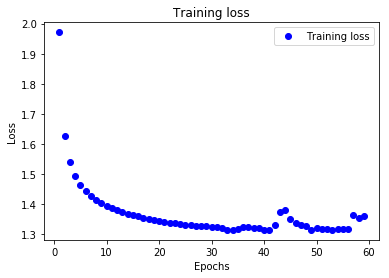

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

The plot shows that the loss generally decreases, but there are occasional burst of deteriorating loss. In our case, the lowest loss is at about 40 epochs, so let's load the weights saved at 40 epochs and use them to generate new text.

In [17]:
model.load_weights('generation_model_epoch40.h5')

In [23]:
text_seed = "let me be pardoned, as an old philologist who cannot desist from the mischief"[:maxlen]
print("Text seed:", text_seed)
generate_text(model, text_seed)

Text seed: let me be pardoned, as an old philologist who cannot desist 
------ temperature: 0.2
let me be pardoned, as an old philologist who cannot desist in the contrary to the same the sense of the desire of the constraint of the most experience of the same the problem of the most contrary to the contrary to the same and the constraint of the most sure of the same constrained to the problem of the same and sure in the same contemptine and the same artist of the most constraint of the contrary to the same artist of the constant that the world of th
------ temperature: 0.5
let me be pardoned, as an old philologist who cannot desist of the basic of the commence and action of the problem of the case the sacrificed to an attention of his own spirit of the conceptions of the most anciorss that it is it no death" self-disguise, and the pride of despair of the problem and the more for a has been the problem of his sure of the contrary to the conduct, the body and for the conceptions and ama

/home/diego/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


mane to put
clo



As you can see, a low temperature results in extremely repetitive and predictable text, but where local structure is highly realistic: in 
particular, most words (a word being a local pattern of characters) are real English words. With higher temperatures, the generated text 
becomes more interesting, surprising, even creative; it may sometimes invent completely new words that sound somewhat plausible (such as 
"eterned" or "troveration"). With a high temperature, the local structure starts breaking down and most words look like semi-random strings 
of characters. Without a doubt, here 0.5 is the most interesting temperature for text generation in this specific setup. Always experiment 
with multiple sampling strategies! A clever balance between learned structure and randomness is what makes generation interesting.

For your reference, below is the original text by Nietzsche:

```
22. Let me be pardoned, as an old philologist who cannot desist from
the mischief of putting his finger on bad modes of interpretation, but
"Nature's conformity to law," of which you physicists talk so proudly,
as though--why, it exists only owing to your interpretation and bad
"philology." It is no matter of fact, no "text," but rather just a
naively humanitarian adjustment and perversion of meaning, with which
you make abundant concessions to the democratic instincts of the modern
soul! 
```

Note that by training a bigger model, longer, on more data, you can achieve generated samples that will look much more coherent and 
realistic than ours. But of course, don't expect to ever generate any meaningful text, other than by random chance: all we are doing is 
sampling data from a statistical model of which characters come after which characters. Language is a communication channel, and there is 
a distinction between what communications are about, and the statistical structure of the messages in which communications are encoded. To 
evidence this distinction, here is a thought experiment: what if human language did a better job at compressing communications, much like 
our computers do with most of our digital communications? Then language would be no less meaningful, yet it would lack any intrinsic 
statistical structure, thus making it impossible to learn a language model like we just did.




## Take aways

* We can generate discrete sequence data by training a model to predict the next tokens(s) given previous tokens.
* In the case of text, such a model is called a "language model" and could be based on either words or characters.
* Sampling the next token requires balance between adhering to what the model judges likely, and introducing randomness.
* One way to handle this is the notion of _softmax temperature_. Always experiment with different temperatures to find the "right" one.